- Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from utils.model_utils import Plotter
import shap

c:\Users\celin\OneDrive\Desktop\Bootcamp\mlenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Import prepocessed data

In [2]:
df = pd.read_csv('ml_data.csv')

- Isolate the target column and select feature columns

In [3]:
features = ['zip_code', 'type_of_property', 'building_condition',
       'facade_number', 'living_area', 'equipped_kitchen', 'terrace', 
       'subtype_ecoded', 'latitude', 'longitude', 'km_to_capital']
target = 'price'

- Apply logarithm to the target col, so larger values are more compressed than small ones, making it easier for the model to handle outliers.

In [4]:
df['price'] = np.log1p(df['price'])

- Define X and y data

In [5]:
X = df[features].values
y = df['price'].values.reshape(-1,1)

- Normalize the data

In [6]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y) 

- Split X and y into train and test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

- Build the model

In [8]:
model = Sequential()
model.add(Dense(128, input_shape=(len(features),), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) # output layer

# Set an optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

c:\Users\celin\OneDrive\Desktop\Bootcamp\mlenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- Train the model  

In [9]:
monitor = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=15, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test[:1000], y_test[:1000]), callbacks=[monitor], shuffle=False, epochs=100, batch_size=32)

Epoch 1/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5171 - mae: 0.5402 - val_loss: 0.2815 - val_mae: 0.4052
Epoch 2/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3187 - mae: 0.4241 - val_loss: 0.2547 - val_mae: 0.3839
Epoch 3/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2828 - mae: 0.4002 - val_loss: 0.2418 - val_mae: 0.3715
Epoch 4/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2707 - mae: 0.3904 - val_loss: 0.2353 - val_mae: 0.3682
Epoch 5/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2592 - mae: 0.3829 - val_loss: 0.2263 - val_mae: 0.3597
Epoch 6/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2505 - mae: 0.3769 - val_loss: 0.2266 - val_mae: 0.3606
Epoch 7/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2416 - mae: 0.3702 - val_loss: 0.2228 - val_mae: 0.3561
Epoch 8/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2406 - mae: 0.3694 - val_loss: 0.2203 - val_mae: 0.3538
Epoch 9/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

- Plot train/validation loss vs. epochs

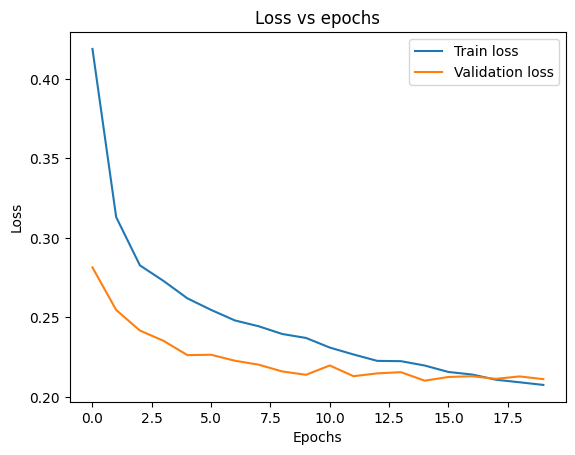

In [10]:
loss_plot_name = 'Loss vs epochs'
train_loss = history.history['loss']
train_legend = 'Train loss'
loss_plot_x_label = 'Epochs'
val_loss = history.history['val_loss']
loss_plot_val2_legend = 'Validation loss'
loss_plot_y_label = 'Loss'
loss_pred_plot = Plotter(loss_plot_name, train_loss, train_legend, loss_plot_x_label, val_loss, loss_plot_val2_legend, loss_plot_y_label)
loss_pred_plot.make_plot()

- Predict on train set and convert results into real values.

In [11]:
pred_train = model.predict(X_train)
# Convert to real numbers
pred_train_l = scaler_y.inverse_transform(pred_train)
pred_train_actual = np.expm1(pred_train_l)

# y_ train back to real values
y_train_l = scaler_y.inverse_transform(y_train)
y_train_actual = np.expm1(y_train_l)

415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


- Make predictions on test set 1 (batch of unseen data) and convert them back to real values.

In [12]:
X_test1 = X_test[:1000]
y_test1 = y_test[:1000]

predictions = model.predict(X_test1)

# reverse the scaled data:
predictions_l = scaler_y.inverse_transform(predictions)

# reverse the logarithm applied to target (price)
predictions_actual = np.expm1(predictions_l)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [13]:
# Same process for the actual values of the price col
y_test1_l = scaler_y.inverse_transform(y_test1)
y_test_actual = np.expm1(y_test1_l)

- Evaluate the model

In [14]:
# MAE training/test
mae_train = np.mean(np.abs(y_train_actual - pred_train_actual))
print(f'MAE training set: {mae_train}')

mae_test = np.mean(np.abs(y_test_actual - predictions_actual))
print(f'MAE test set: {mae_test}')

MAE training set: 83955.0534332643
MAE test set: 80752.1968203125


In [15]:
# RMSE training/test
rmse_train = root_mean_squared_error(pred_train_actual, y_train_actual)
print("RMSE on train set:", rmse_train)

rmse_test = root_mean_squared_error(y_test_actual, predictions_actual)
print("RMSE on test set:", rmse_test)

RMSE on train set: 140504.69186517928
RMSE on test set: 134207.30742733748


In [16]:
# R2 training/test
r2_train = r2_score(y_train_actual, pred_train_actual)
print(f"Train R^2 on training set: {r2_train}")

r2_test = r2_score(y_test_actual, predictions_actual)
print(f"Test R^2 on test set: {r2_test}")

Train R^2 on training set: 0.7087799367965363
Test R^2 on test set: 0.7025570477685672


In [17]:
# MAPE on train/test sets
mape_train = np.mean(np.abs((y_train_actual - pred_train_actual) / y_train_actual) * 100)
mape_train = round(mape_train, 2)
print(f"MAPE on train set: {mape_train} %")


mape_test = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual) * 100)
mape_test = round(mape_test, 2)
print(f"MAPE on test set: {mape_test} %")

MAPE on train set: 19.77 %
MAPE on test set: 19.74 %


In [18]:
predictions_actual[:5]

array([[465318.22],
       [195583.4 ],
       [363356.2 ],
       [355497.97],
       [413304.75]], dtype=float32)

In [19]:
y_test_actual[:5]

array([[529000.],
       [169000.],
       [229000.],
       [285000.],
       [249000.]])

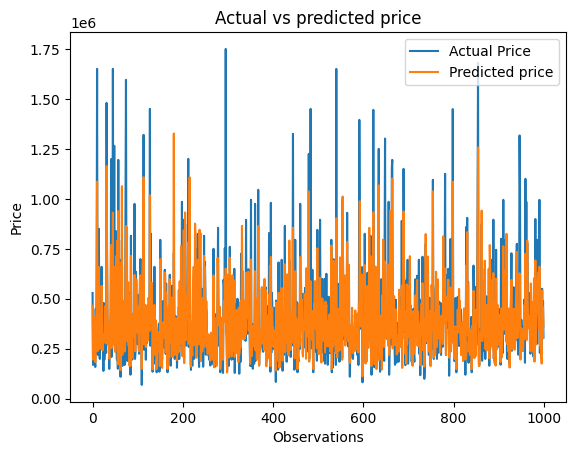

In [20]:
plot_name = "Actual vs predicted price"
plot_val1_legend = 'Actual Price'
plot_x_label = 'Observations'
plot_val2_legend = 'Predicted price'
plot_y_label = 'Price'
pred_plot = Plotter(plot_name, y_test_actual, plot_val1_legend, plot_x_label, predictions_actual, plot_val2_legend, plot_y_label)
pred_plot.make_plot()

- Visualize feature importance with shap

PermutationExplainer explainer: 251it [01:16,  3.14it/s]                         


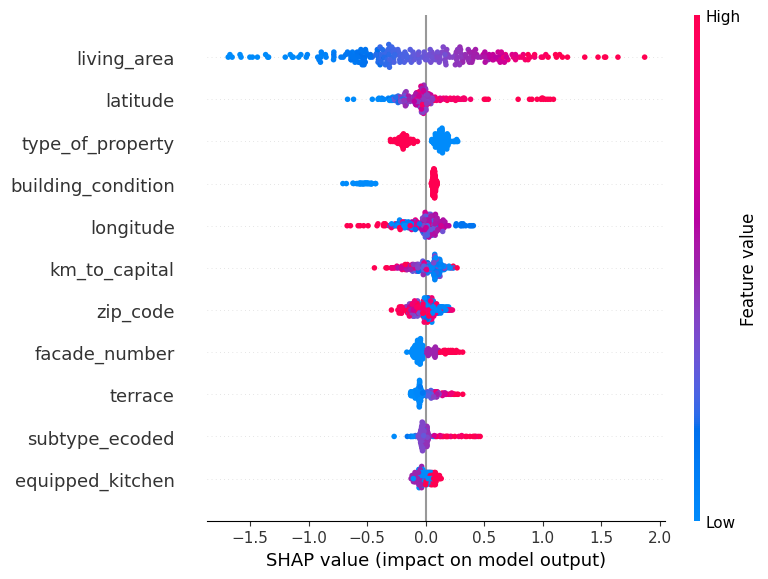

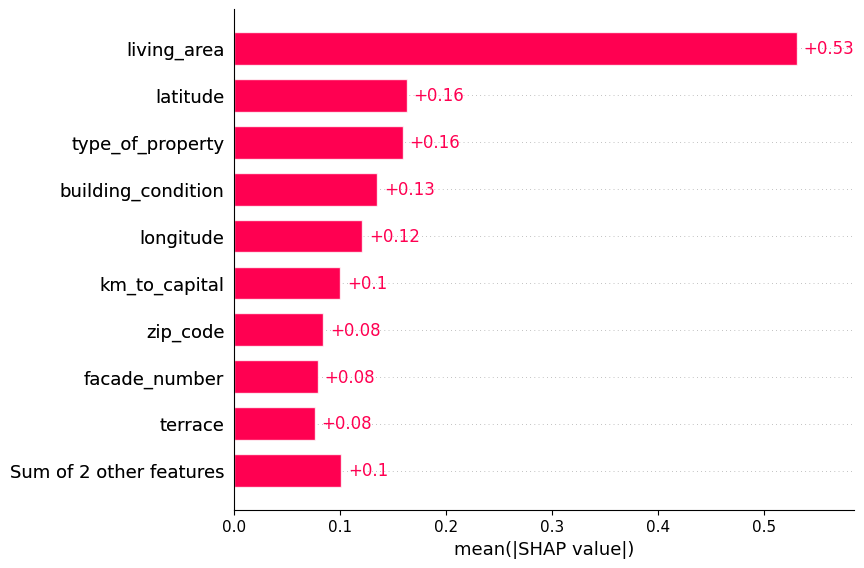

In [21]:
explainer = shap.Explainer(model, X_train)
sample = X_train[:250]
shap_values = explainer(sample)
shap_values.feature_names = features
shap.summary_plot(shap_values, sample)
shap.plots.bar(shap_values)